## Warning!
This notebook is only for experimental purposes while learning, working with data of Ashrae Kaggle Competition. It won't be part of the final project, and will be removed from the repository.

### Training data sets structure

**train.csv**
* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
* `timestamp`  - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

**building_meta.csv**
* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

**weather_[train/test].csv**

Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

##  Loading data

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import datetime as dt
import gc
from src.functions import utils as utl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Importing data
train = utl.import_data('../data/raw/train.csv') 


Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


In [3]:
building_meta = utl.import_data('../data/raw/building_metadata.csv')

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


In [4]:
weather_train = utl.import_data('../data/raw/weather_train.csv')

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


## Wrangling


#### Data set `building_meta` 

In [5]:
building_meta.shape

(1449, 6)

In [6]:
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [7]:
building_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int8
building_id    1449 non-null int16
primary_use    1449 non-null category
square_feet    1449 non-null int32
year_built     675 non-null float16
floor_count    355 non-null float16
dtypes: category(1), float16(2), int16(1), int32(1), int8(1)
memory usage: 17.8 KB


El campo `year_built` es de tipo `float`. Vamos a convertirlo a `str`, quitándole además el decimal

In [8]:
building_meta['year_built'] = building_meta['year_built'].astype(str, errors='ignore')

In [9]:
f = lambda x: x.replace('.0','')
building_meta['year_built'] = building_meta['year_built'].apply(f)

In [10]:
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008,NaN
1,0,1,Education,2720,2004,NaN
2,0,2,Education,5376,1991,NaN
3,0,3,Education,23685,2002,NaN
4,0,4,Education,116607,1975,NaN


** Missing values **

In [11]:
building_meta.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built        0
floor_count    1094
dtype: int64

In [12]:
building_meta[building_meta['floor_count'].isna()].tail()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1444,15,1444,Entertainment/public assembly,19619,1914,NaN
1445,15,1445,Education,4298,nan,NaN
1446,15,1446,Entertainment/public assembly,11265,1997,NaN
1447,15,1447,Lodging/residential,29775,2001,NaN
1448,15,1448,Office,92271,2001,NaN


** Duplicated observations **

In [13]:
building_meta[building_meta.duplicated()].sum()

site_id        0.0
building_id    0.0
primary_use    0.0
square_feet    0.0
year_built     0.0
floor_count    0.0
dtype: float64

#### Data set `train`

In [14]:
train.shape

(20216100, 4)

In [15]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        category
meter_reading    float32
dtypes: category(1), float32(1), int16(1), int8(1)
memory usage: 173.9 MB


In [17]:
train.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [18]:
train[train.duplicated()].sum()

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

#### Data set `weather_train`

In [19]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [20]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null category
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: category(1), float16(7), int8(1)
memory usage: 2.6 MB


In [21]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [22]:
weather_train[weather_train.duplicated()].sum()

site_id               0.0
timestamp             0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
precip_depth_1_hr     0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
dtype: float64

#### Merging data sets

In [23]:
# train + building by FK 'building_id'
merge_1 = pd.merge(train, building_meta, how='left', on='building_id')

In [24]:
merge_1.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975,NaN


In [25]:
df = pd.merge(merge_1, weather_train, how='left', on=['site_id','timestamp'])

In [26]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [27]:
del(train, weather_train, building_meta, merge_1)

In [28]:
gc.collect()

334

In [29]:
# Saving as csv file 
# df.to_csv('../data/processed/df_merged')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             category
meter_reading         float32
site_id               int8
primary_use           category
square_feet           int32
year_built            object
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: category(2), float16(8), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 906.5+ MB


In [31]:
df[df['floor_count'].notnull()]['floor_count'].head()

103     5.0
104     4.0
105     4.0
106    10.0
107     5.0
Name: floor_count, dtype: float16

In [32]:
df.isna().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built                   0
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

In [33]:
df.memory_usage().sum()/1024**2

906.5202903747559

In [34]:
# Rearranging columns
cols = df.columns.tolist()

In [35]:
cols = [
    'site_id', 
    'building_id', 
    'year_built', 
    'primary_use', 
    'floor_count', 
    'meter', 
    'timestamp', 
    'air_temperature', 
    'cloud_coverage',
    'dew_temperature',
    'precip_depth_1_hr',
    'sea_level_pressure',
    'wind_direction',
    'wind_speed',
    'meter_reading'
]

In [36]:
df = df[cols]

In [37]:
df.head()

,site_id,building_id,year_built,primary_use,floor_count,meter,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0,0,2008,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
1,0,1,2004,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
2,0,2,1991,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
3,0,3,2002,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
4,0,4,1975,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0


## Data quality assessment and profiling

### Handling missing values

In [38]:
df.isna().sum()

site_id                      0
building_id                  0
year_built                   0
primary_use                  0
floor_count           16709167
meter                        0
timestamp                    0
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
meter_reading                0
dtype: int64

#### Variable `floor_count`

There're more than 16 million of `NaN` values in `floor_count`. They're likely to be buildings with only ground-floor. We're filling this missing values with `0` and, by the way, we're casting the type of this variable to int, as now it is a float.

In [39]:
df['floor_count'] = df['floor_count'].fillna(0.0).astype(int)

In [40]:
df.head()

,site_id,building_id,year_built,primary_use,floor_count,meter,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0,0,2008,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
1,0,1,2004,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
2,0,2,1991,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
3,0,3,2002,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
4,0,4,1975,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0


In [16]:
df.isna().sum()

site_id                     0
building_id                 0
year_built                  0
primary_use                 0
floor_count                 0
meter                       0
timestamp                   0
air_temperature         96658
cloud_coverage        8825365
dew_temperature        100140
precip_depth_1_hr     3749023
sea_level_pressure    1231669
wind_direction        1449048
wind_speed             143676
meter_reading               0
dtype: int64

#### Remaining features

Let's visualize the distribution of missing values, using a sample of `df` data set, as it's very large and may cause memory errors:

In [41]:
df_sample = df.sample(500000, replace=False, random_state=666)

In [42]:
df_sample.to_csv('../data/interim/df_sample.csv')

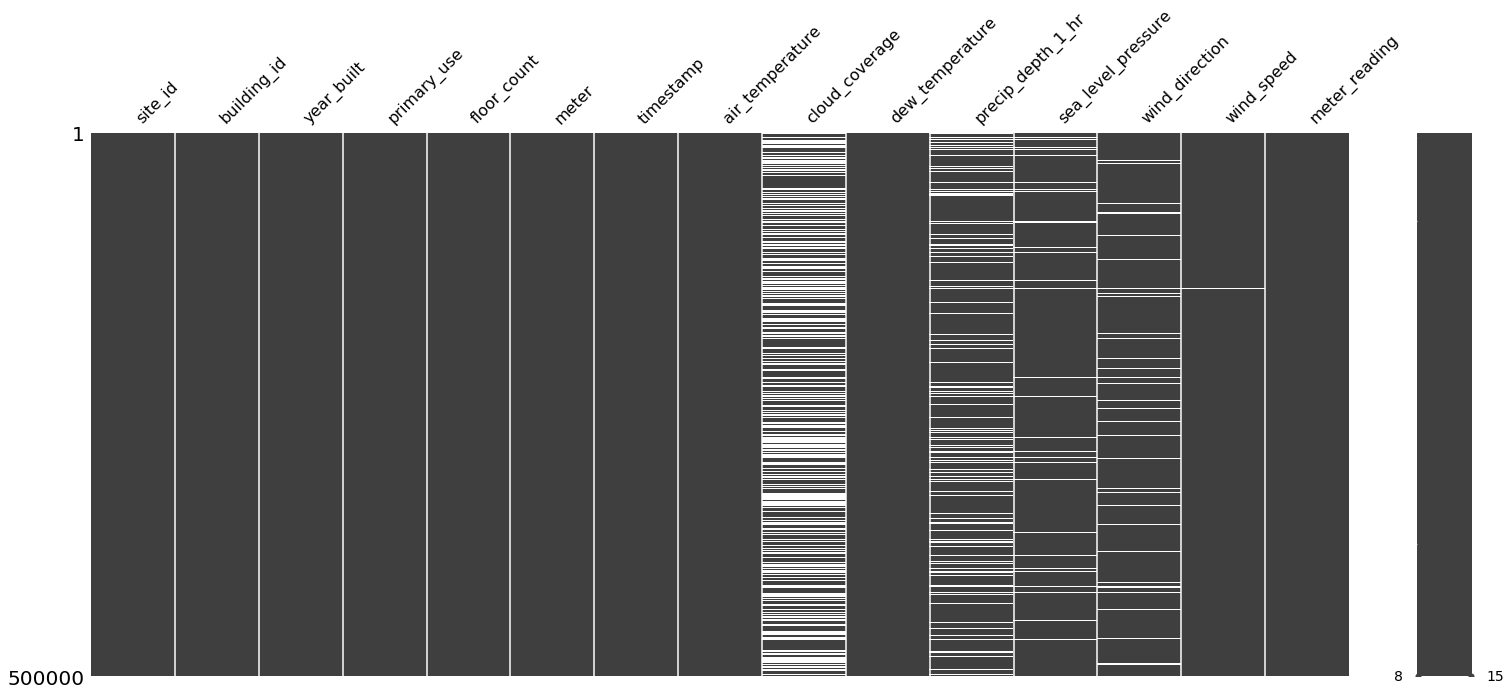

In [18]:
msno.matrix(df_sample)

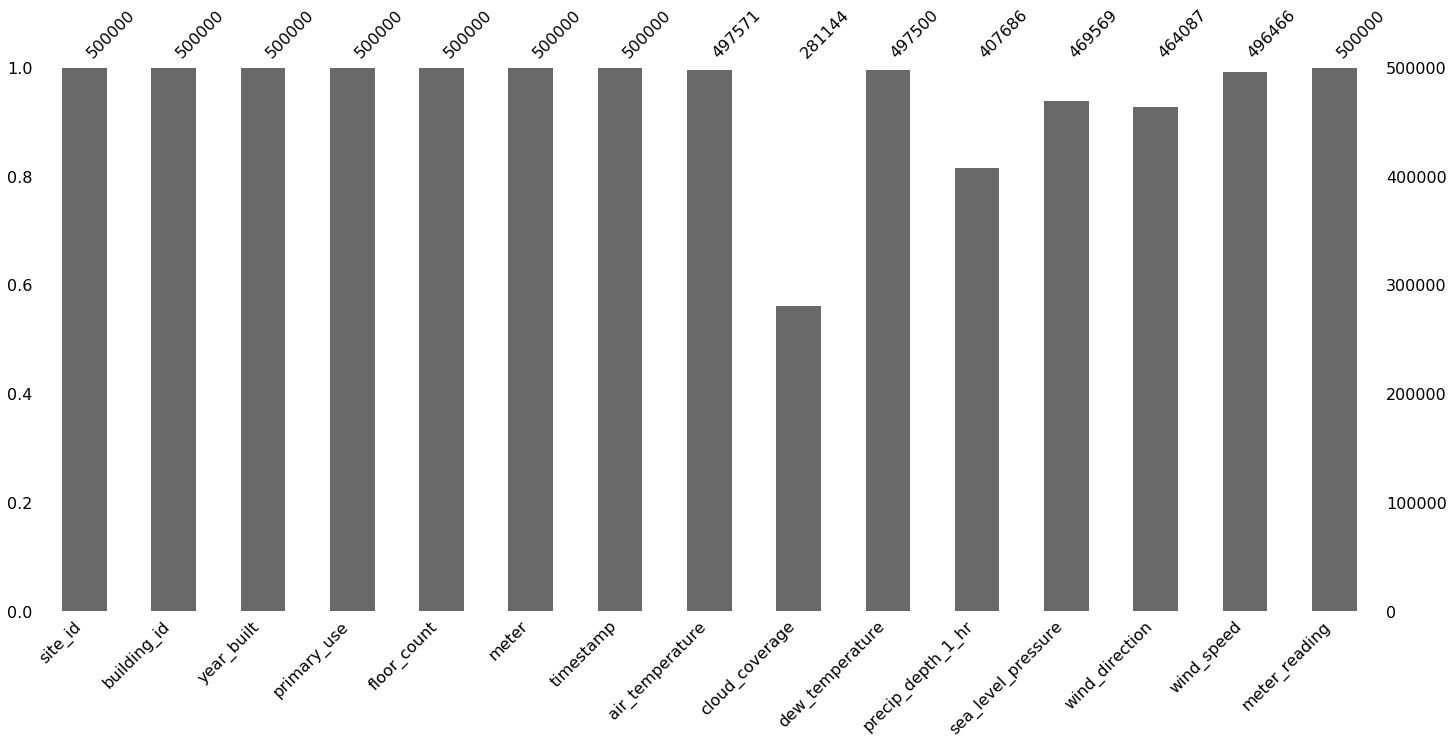

In [19]:
msno.bar(df_sample)

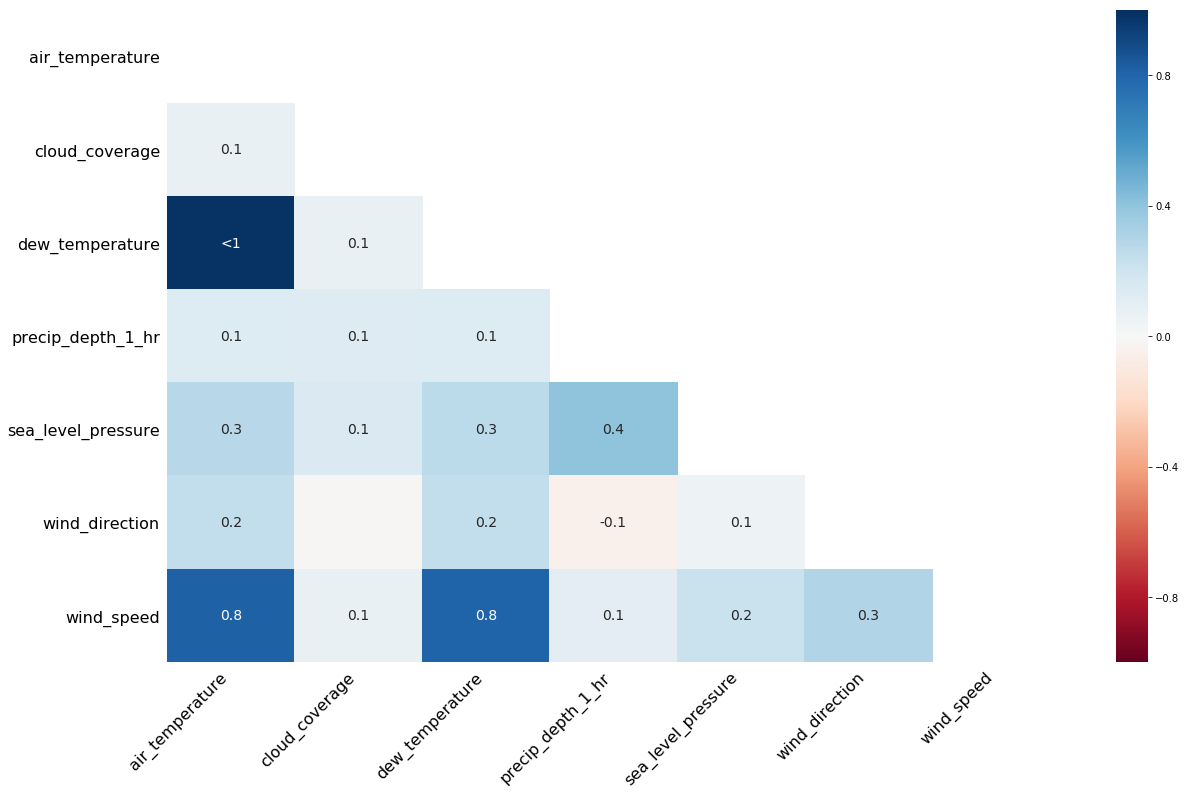

In [20]:
msno.heatmap(df_sample)

There's high correlation in the distribution of `NaN`values between variables `air_temperature`, `dew_temperature` and `wind_speed`. Also there's is a significative correlation in the missing values distribution for `precip_depth_1_hr`and `sea_level_preassure`.

The feature with most of missing values is `cloud_coverage`, and it doesn't seem to be a correlation with any other feature, regarding `NaN` values.

We need a little more information to be able to decide what to do with missing values. A correlation plot between features could be a good advisor. We're only interested in weather variables, as the rest have no missing values.

C:\Users\Victor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\Victor\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


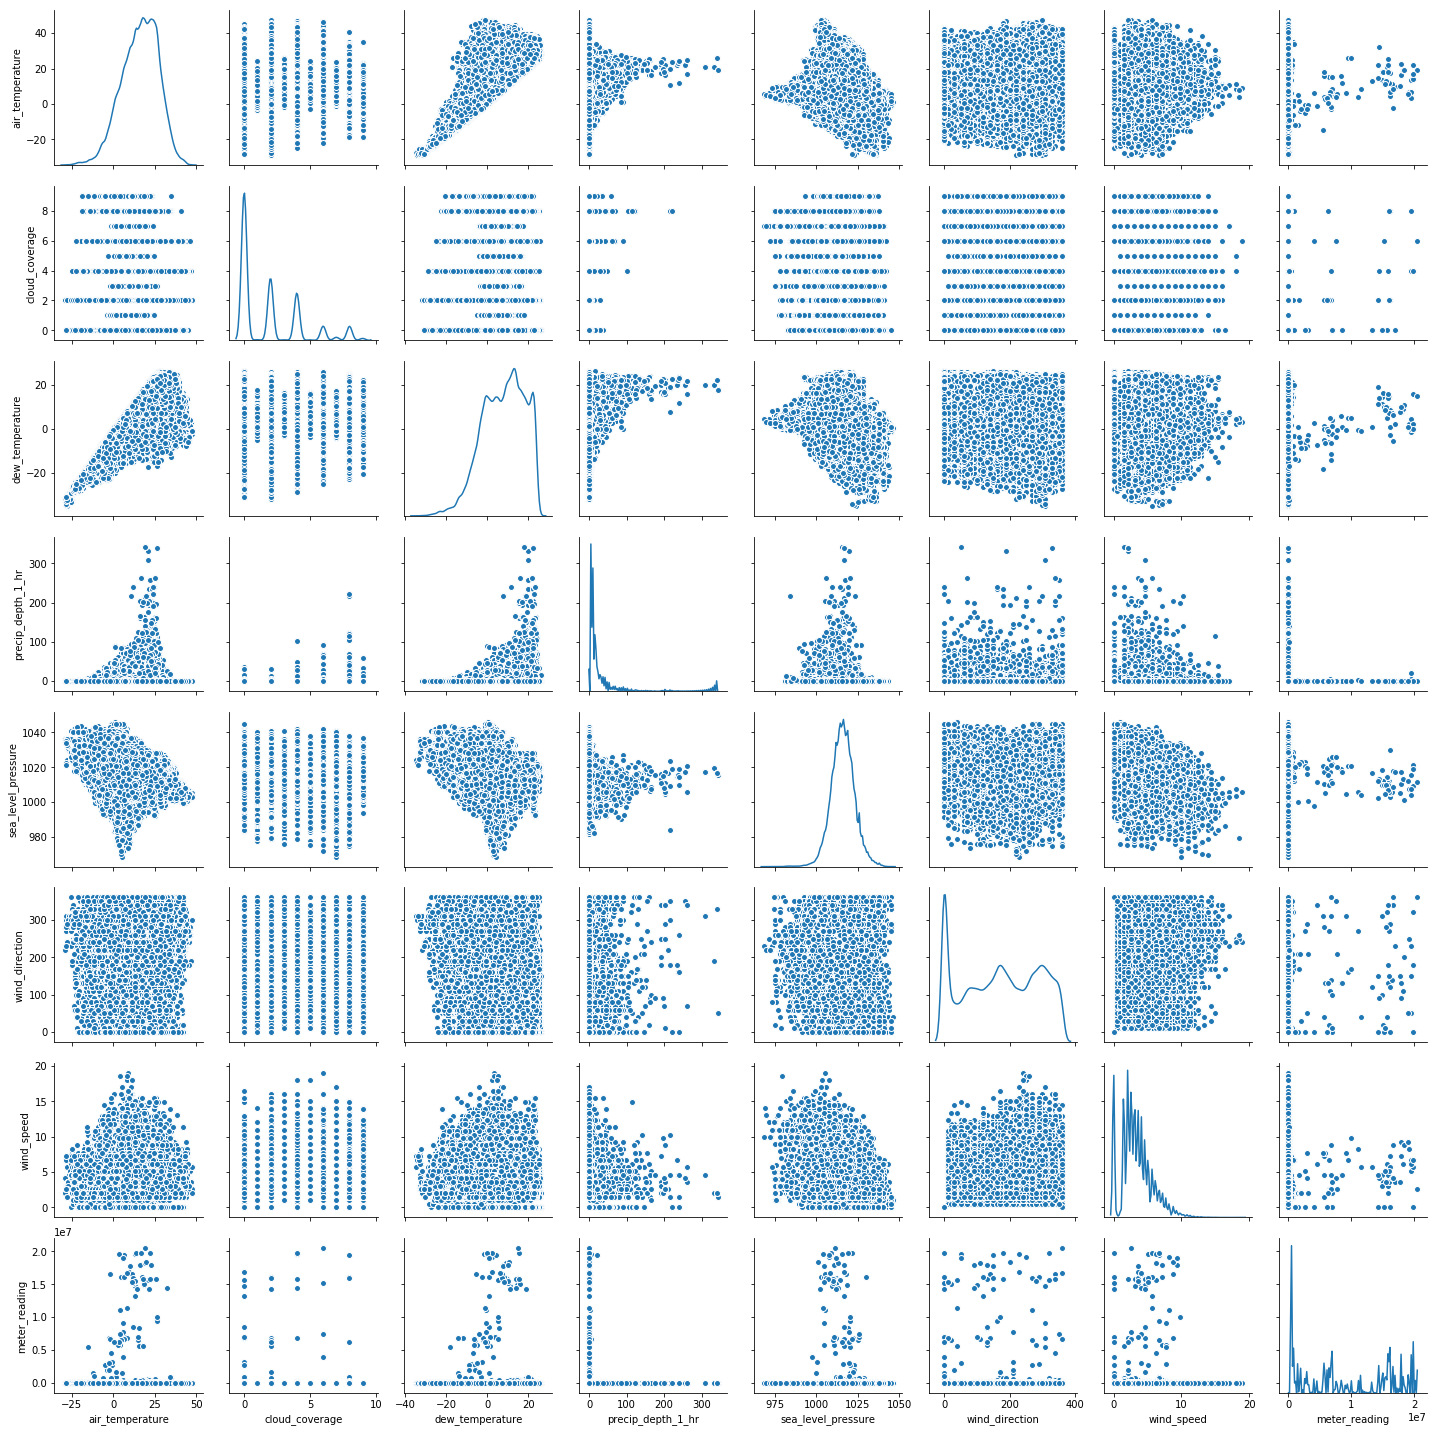

In [21]:
sns.pairplot(df_sample.loc[:, 'air_temperature':], diag_kind='kde')